# Advanced NLP HW0

Before starting the task please read thoroughly these chapters of Speech and Language Processing by Daniel Jurafsky & James H. Martin:

•	N-gram language models: https://web.stanford.edu/~jurafsky/slp3/3.pdf

•	Neural language models: https://web.stanford.edu/~jurafsky/slp3/7.pdf 

In this task you will be asked to implement the models described there.

Build a text generator based on n-gram language model and neural language model.
1.	Find a corpus (e.g. http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt ), but you are free to use anything else of your interest
2.	Preprocess it if necessary (we suggest using nltk for that)
3.	Build an n-gram model
4.	Try out different values of n, calculate perplexity on a held-out set
5.	Build a simple neural network model for text generation (start from a feed-forward net for example). We suggest using tensorflow + keras for this task

Criteria:
1.	Data is split into train / validation / test, motivation for the split method is given
2.	N-gram model is implemented
a.	Unknown words are handled
b.	Add-k Smoothing is implemented
3.	Neural network for text generation is implemented
4.	Perplexity is calculated for both models
5.	Examples of texts generated with different models are present and compared
6.	Optional: Try both character-based and word-based approaches.

#Imports

We need nltk 3.4.5

In [4]:
! pip uninstall nltk

Uninstalling nltk-3.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/nltk-3.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/nltk/*
Proceed (y/n)? y
  Successfully uninstalled nltk-3.2.5


In [5]:
! pip install nltk==3.4.5

     |████████████████████████████████| 1.5MB 2.7MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=90cafdca199db984873214b2ce676ff1b0446e319502bc06931274c1eb48ed67
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [0]:
import nltk

In [7]:
nltk.__version__

'3.4.5'

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import unicodedata
import re
import inflect
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.lm import NgramCounter

from collections import Counter

from functools import partial
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Load data

In [10]:
! wget -c https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt

--2020-03-01 11:32:46--  https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: ‘shakespeare_input.txt’

shakespeare_input.t 100%[===================>]   4.36M  3.93MB/s    in 1.1s    

2020-03-01 11:32:48 (3.93 MB/s) - ‘shakespeare_input.txt’ saved [4573338/4573338]



#Preprocessing

##Loading text

Read text as one string

In [0]:
input_file = open("shakespeare_input.txt", "r")
input_string = input_file.read()

Number of characters

In [0]:
len(input_string)

4573338

In [0]:
input_string[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

Perpesent text as list of sentences

In [0]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
text = sent_detector.tokenize(input_string.strip())

Make some replacement

In [0]:
replacement_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot",
                        "'cause": "because", "could've": "could have", "couldn't": "could not",
                        "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                        "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                        "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                        "i'd": "i would", "i'd've": "i would have", "i'll": "I will",
                        "i'll've": "i will have","i'm": "i am", "i've": "i have", "i'd": "i would",
                        "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", 
                        "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                        "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                        "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                        "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                        "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                        "she's": "she is", "should've": "should have", "shouldn't": "should not",
                        "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                        "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                        "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                        "here's": "here is","they'd": "they would", "they'd've": "they would have",
                        "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                        "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                        "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                        "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                        "what'll've": "what will have", "what're": "what are",  "what's": "what is",
                        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                        "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                        "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                        "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                        "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                        "y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                        "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                        "'t": " it", "'em": "them", "o'": "of", "'ll": " will", "ne'er":"never", "'ld": " would", "i'": "in",
                        "'d": "ed", "'en ": "ken ", "'bout":"about", "'gainst":"against", "'scape":"escape", "'mongst": "amongst", 
                        "'n": "en", "e'er":"ever", "itwas":"it was" }

In [0]:
def replace_phrases(sentence, phrases_dict):
  for key, value in phrases_dict.items():
    sentence = sentence.replace(key, value)
  return sentence

In [0]:
replacer = partial(replace_phrases, phrases_dict=replacement_dict)
text = list(map(replacer, text))

Tokenize each sentence

In [0]:
text_in_words = list(map(nltk.word_tokenize, text))

We need to make normalization:

*remove non ascii characters from words

*to lower_case???

*replace numbers

*remove stopwords???

##Basic preprocessing functions

In [0]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [0]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [0]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s\<\>\/]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [0]:
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [0]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [0]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_words(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return lemmas

## Using only some preprocessing

In [0]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
    return words

In [0]:
text_in_words_normalized = list(map(normalize, text_in_words))

Let's pad sentences

In [0]:
def padder(sentence):
  return list(nltk.lm.preprocessing.pad_both_ends(sentence,n=2))
text_in_words_padded = list(map(padder, text_in_words_normalized))

In [0]:
text_in_words_padded[0]

['<s>',
 'first',
 'citizen',
 ':',
 'before',
 'we',
 'proceed',
 'any',
 'further',
 ',',
 'hear',
 'me',
 'speak',
 '.',
 '</s>']

## Incapsulate into classes

In [0]:
class TextLoader():
  """
  This class loads text from text file and tokenizes it by sentences
  """
  def __init__(self):
    pass
  
  def load_text_by_sentences(self, filename):
    # read raw text
    with open(filename, "r") as input_file: 
      input_string = input_file.read()
    # split by sentences
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    return sent_detector.tokenize(input_string.strip())

In [0]:
class Preprocessor():
  """
  This class preprocesses text (splitted by sentences): replaces some phrases, removes non-ascii characters and etc.
  """
  def __init__(self, n):
    self.__n = n
    self.__replacement_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot",
                        "'cause": "because", "could've": "could have", "couldn't": "could not",
                        "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                        "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                        "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                        "i'd": "i would", "i'd've": "i would have", "i'll": "I will",
                        "i'll've": "i will have","i'm": "i am", "i've": "i have", "i'd": "i would",
                        "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", 
                        "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                        "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                        "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                        "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                        "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                        "she's": "she is", "should've": "should have", "shouldn't": "should not",
                        "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                        "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                        "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                        "here's": "here is","they'd": "they would", "they'd've": "they would have",
                        "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                        "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                        "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                        "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                        "what'll've": "what will have", "what're": "what are",  "what's": "what is",
                        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                        "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                        "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                        "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                        "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                        "y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                        "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                        "'t": " it", "'em": "them", "o'": "of", "'ll": " will", "ne'er":"never", "'ld": " would", "i'": "in",
                        "'d": "ed", "'en ": "ken ", "'bout":"about", "'gainst":"against", "'scape":"escape", "'mongst": "amongst", 
                        "'n": "en", "e'er":"ever", "itwas":"it was" }

  @staticmethod
  def __replace_phrases(sentence, phrases_dict):
    # replace sentences accordingly to given dictionary
    for key, value in phrases_dict.items():
      sentence = sentence.replace(key, value)
    return sentence

  @staticmethod
  def __preprocess_sentence(words):
    """
    Removes non-ascii characters, converts to lowercase, replaces numbers
    """
    def remove_non_ascii(words):
      """Remove non-ASCII characters from list of tokenized words"""
      new_words = []
      for word in words:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
      return new_words

    def to_lowercase(words):
      """Convert all characters to lowercase from list of tokenized words"""
      new_words = []
      for word in words:
          new_word = word.lower()
          new_words.append(new_word)
      return new_words
      
    def replace_numbers(words):
      """Replace all interger occurrences in list of tokenized words with textual representation"""
      p = inflect.engine()
      new_words = []
      for word in words:
          if word.isdigit():
              new_word = p.number_to_words(word)
              new_words.append(new_word)
          else:
              new_words.append(word)
      return new_words

    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
    return words

  @staticmethod
  def __padder(sentence, n):
      return list(nltk.lm.preprocessing.pad_both_ends(sentence,n))


  def normalize(self, text_in_sentences):
    # replace sentences according to given dictionary
    replacer = partial(Preprocessor.__replace_phrases, phrases_dict=self.__replacement_dict)
    text = list(map(replacer, text_in_sentences))

    # tokenize each sentence into words
    text_in_sentences_splitted_by_words = list(map(nltk.word_tokenize, text))
    
    # preprocess words in each sentences
    text_in_sentences_splitted_by_words_normalized = list(map(Preprocessor.__preprocess_sentence,\
                                                              text_in_sentences_splitted_by_words))
    # pad each sentence from begging and end by special characters <s> </s>
    padder = partial(Preprocessor.__padder, n=self.__n)
    text_prepared = list(map(padder, text_in_sentences_splitted_by_words_normalized))

    return text_prepared
  


In [0]:
text_loader = TextLoader()
full_text = text_loader.load_text_by_sentences('shakespeare_input.txt')
preprocessor = Preprocessor(n=5)
full_text_preprocessed = preprocessor.normalize(full_text)

In [0]:
len(full_text_preprocessed)

52482

In [0]:
len(text_in_words_padded)

52482

# Models

Short pipeline description:
1.   Load text in sentences
2.   Split into train/val/test (in sentences)
3.   Inside update and perplexity evaluation incoming sequence of sentences will be preprocessed: normalized and padded



##N gram model with k-add smoothing

In [0]:
class NgramModel:
  def __init__(self, n, k, vocab = None):
    """Language model constructor
    n -- n-gram size
    vocab -- optional fixed vocabulary for the model
    """
    self.n = n
    self.vocab = vocab
    self.k = k
    # create instance of preprocessor to normalize incoming text
    self.preprocessor = Preprocessor(n)

  def prob(self, word, context=None):
    """This method returns probability of a word with given context: P(w_t | w_{t - 1}...w_{t - n + 1})
    
    For example:
    >>> lm.prob('hello', context=('world',))
    0.99988
    """
    return (self.text_ngrams[tuple(context)+(word,)] + self.k) / (self.text_n_minus_one_grams[tuple(context)] + self.k*len(self.vocab))
    

  def generate_text(self, text_length):
    """This method generates random text of length 
    
    For example
    >>> lm.generate_text(2)
    hello world

    """
    # we begin from <s><s>... n-1 times
    text = ['<s>'] * (self.n-1)
    for j in range(text_length):
      # evaluate probabilities of each word for current context
      probs = np.zeros(shape=(len(self.vocab)))
      for i, word in enumerate(self.vocab):
        probs[i] = self.prob(word=word, context=text[j:])
      # normalize probabilitities due to some computational issues
      probs = np.asarray(probs).astype('float64')
      probs = probs / np.sum(probs)
      # generate word index accordingly to distribution
      rv = np.random.multinomial(1, probs, 1)
      idx = rv.argmax()
      # add word to text
      text.append(self.vocab[idx])
    # postprocess generated text
    str_text = ' '. join(text)
    str_text = str_text.replace('<s> ', "")
    str_text = str_text.replace(' </s>', "")
    return str_text

  def update(self, sequence_of_tokens):
    """This method learns probabiities based on given sequence of tokents
    
    sequence_of_tokens -- iterable of tokens

    For example
    >>> lm.update(['hello', 'world'])
    """
    # preprocess input sequence
    normalized_sequence = self.preprocessor.normalize(sequence_of_tokens)

    # merge into one list of words
    words_list = []
    for sent in normalized_sequence:
      words_list += sent 
    # calculate ngrams and n-1 grams  
    self.text_ngrams = Counter(ngrams(words_list, self.n))
    self.text_n_minus_one_grams = Counter(ngrams(words_list, self.n-1))

    # save vocabulary
    self.vocab = list(set(words_list))
    
  def perplexity(self, sequence_of_tokens):
    """This method returns perplexity for a given sequence of tokens
    
    sequence_of_tokens -- iterable of tokens
    """
    # preprocess input sequence
    normalized_sequence = self.preprocessor.normalize(sequence_of_tokens)

    # merge into one list of words
    words_list = []
    for sent in normalized_sequence:
      words_list += sent 

    log_prob = 0
    for i in range(self.n-1,len(words_list)):
      log_prob += np.log(self.prob(word=words_list[i],
                                   context=words_list[i-(self.n-1):i]))
    return np.exp(-log_prob/len(words_list))

Load text and split it into train and test

In [0]:
def split(full_text, train_fraction, val_fraction):
  length = len(full_text)
  train, val, test = full_text[:int(train_fraction*length)],\
                     full_text[int(train_fraction*length):int((train_fraction+val_fraction)*length)],\
                     full_text[int((train_fraction+val_fraction)*length):]
  return train, val, test

In [0]:
text_loader = TextLoader()
full_text = text_loader.load_text_by_sentences("shakespeare_input.txt")
train_text, val_text, test_text = split(full_text, 0.5, 0.3)

In [41]:
model = NgramModel(n=5,k=1)
model.update(train_text)
print(model.perplexity(val_text))

2652.3228435544115


Validation

In [0]:
perplexity_list = []
for n in range(2,7):
  model = NgramModel(n=n,k=1)
  model.update(train_text)
  perplexity_list.append(model.perplexity(val_text))

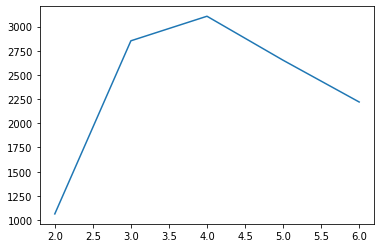

In [0]:
plt.plot(list(range(2,7)), perplexity_list)

We choose model with minimal perplexity, which implies maximum probability of validation set

In [54]:
model = NgramModel(n=2,k=1)
model.update(train_text)
print(model.perplexity(test_text))

1117.6749768007317


In [55]:
print(model.generate_text(100))

truly scold ought clearest unconsidered nourished all-ending mouth-made swear fist lute-string superstitiously wallets adultress repossess judgment-day ross hates necessities barren discovery poll contract assuredly astonish spoils roguish cradles banners abode spectatorship marble-constant fearful'st faced john lovingly pastime divers changes well-divided 'true surmise foxes big-swoln defend reeking revolted jealousies unloads browsed'st camp gets 'kind achieves hostage helpers christophero placed wanderers temple-garden twelvemonth cneius unreversed sympathy look shear sought'st presumption speken flinty oped humility magnifiest stony-stratford bribes huge oferween lamented accusing tithing bewail curiously tamora bunting charm didofs gambols leagues rich-jeweled rents pursed woolvish branches forsooth rocky-hard unseparable blaze nursing cook plainly


## Neural network model

In [0]:
class NeuralModel:
  def __init__(self, n, n_epochs, vocab = None):
    """Language model constructor
    n -- n-gram size
    vocab -- optional fixed vocabulary for the model
    """
    self.n = n
    self.vocab = vocab
    self.n_epochs = n_epochs
    # create instance of preprocessor to normalize incoming text
    self.preprocessor = Preprocessor(n)


  def log_prob(self, word, context=None):
    """This method returns probability of a word with given context: P(w_t | w_{t - 1}...w_{t - n + 1})
    
    For example:
    >>> lm.prob('hello', context=('world',))
    0.99988
    """
    # enter eval mode
    self.nn_model.eval()
    # transform context in torch tensor
    context = np.array([self.word_to_id.get(word, self.word_to_id['unk']) for word in context])
    context_idxs = torch.tensor(context.reshape(1,-1), dtype=torch.long)
    # sent to gpu
    x_gpu = context_idxs.to(device)   
    # make prediction
    log_probs = self.nn_model(x_gpu).cpu().detach().numpy()
    # return lop_prob for our word
    return log_probs[0,self.word_to_id.get(word, self.word_to_id['unk'])]
    
  def predict_distribution(self, context):
    """This method predicts whole words distribution for given context"""
    # enter eval mode
    self.nn_model.eval()
    # transform context in torch tensor
    context = np.array([self.word_to_id.get(word, self.word_to_id['unk']) for word in context])
    context_idxs = torch.tensor(context.reshape(1,-1), dtype=torch.long)
    # sent to gpu
    x_gpu = context_idxs.to(device)
    # make prediction
    log_probs = self.nn_model(x_gpu).cpu().detach().numpy()
    # return whole distribution over the words
    return log_probs   

  def generate_text(self, text_length):
    """This method generates random text of length 
    
    For example
    >>> lm.generate_text(2)
    hello world

    """
    # we begin from <s><s>... n-1 times
    text = ['<s>'] * (self.n-1)
    for j in range(text_length):
      # evaluate probabilities of each word for current context
      probs = self.predict_distribution(context=text[j:])[0]
      probs = np.asarray(probs).astype('float64')
      probs = probs / np.sum(probs)
      # generate word index accordingly to distribution
      rv = np.random.multinomial(1, probs, 1)
      idx = rv.argmax()
      # add word to text
      text.append(self.vocab[idx])
    # postprocess generated text
    str_text = ' '. join(text)
    str_text = str_text.replace('<s> ', "")
    str_text = str_text.replace(' </s>', "")
    return str_text
  
  @staticmethod
  def construct_samples(text, n, word_to_id):
      X, y = [], []
      number_of_samples = len(text) - n + 1
      for i in range(number_of_samples):
        # if we get unknown word we encode it with number for 'unk' -> word_to_id['unk']
        X.append(np.array([word_to_id.get(word, word_to_id['unk']) for word in text[i:i+n-1]]))
        y.append(np.array(word_to_id.get(text[i+n-1], word_to_id['unk'])))
      # convert to numpy for torch
      X = np.array(X)
      y = np.array(y)
      return X, y

  def update(self, sequence_of_tokens, val_sequence):
    """This method learns probabiities based on given sequence of tokents
    
    sequence_of_tokens -- iterable of tokens

    For example
    >>> lm.update(['hello', 'world'])
    """
    print('Preprocessing stage')
    # preprocess input sequences
    normalized_sequence_train = self.preprocessor.normalize(sequence_of_tokens)
    normalized_sequence_val = self.preprocessor.normalize(val_sequence)
    # merge into one list of words
    words_list_train, words_list_val = [], []
    for sent in normalized_sequence_train:
      words_list_train += sent 

    for sent in normalized_sequence_val:
      words_list_val += sent
    # count frequency of words in train
    count_dict = Counter(words_list_train)
    # find rare words
    rare_words = []
    for key, value in count_dict.items():
      if value <= 2:
        rare_words.append(key)
    # substitute rare words with 'unk'
    words_list_train = [x if x not in rare_words else 'unk' for x in words_list_train]
    self.vocab = list(set(words_list_train))
    self.vocab.append('unk')
    self.voc_size = len(self.vocab)
    

    # create word - index and index - word mappings
    self.word_to_id = {word:i for i, word in enumerate(self.vocab)}
    self.id_to_word = {i:word for word, i in self.word_to_id.items()}

    # create samples for training and validation
    X_train, y_train = NeuralModel.construct_samples(words_list_train, self.n, self.word_to_id)
    X_val, y_val = NeuralModel.construct_samples(words_list_val, self.n, self.word_to_id)

    # prepare network
    print('Start to train network')
    # class for flatting  representation after embedding layer
    class Flattener(nn.Module):
      def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

    # create model
    self.nn_model = nn.Sequential(
              nn.Embedding(self.voc_size, 10),
              Flattener(),
              nn.Linear((self.n-1)*10, 100),
              nn.ReLU(inplace=True),
              nn.Linear(100, self.voc_size),
              nn.LogSoftmax(dim=1)
          )
    # use cuda
    self.nn_model.type(torch.cuda.FloatTensor)
    # define loss - cross - entropy without logarithm, because LogSoftmax is used
    loss_function = nn.NLLLoss().type(torch.cuda.FloatTensor)
    # define optimizer
    optimizer = optim.SGD(self.nn_model.parameters(), lr=1e-2, weight_decay=1e-3)
    # train network
    self.__train_network(optimizer, loss_function, X_train, y_train, X_val, y_val)
  
  def __train_network(self, optimizer, loss_function, X_train, y_train, X_val, y_val):
    train_subset_size = 10000
    val_subset_size = 2000
    batch_size = 1000
    train_losses, val_losses = [], []
    # create scheduler for lr annealing
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)

    for epoch in range(self.n_epochs):
      total_train_loss, total_val_loss = 0, 0
      # enter train mode
      self.nn_model.train()
      # create random subset of train data
      indices = list(range(X_train.shape[0]))
      chosen_indices = np.random.choice(indices,train_subset_size)
      X,y = X_train[chosen_indices,:], y_train[chosen_indices]
      # train by batches
      for i in range(train_subset_size // batch_size):
        # create batch and send to GPU
        context_idxs = torch.tensor(X[i:(i+1)*batch_size, :], dtype=torch.long)
        y_gpu = torch.tensor(y[i:(i+1)*batch_size], dtype=torch.long).to(device)
        x_gpu = context_idxs.to(device)
        # delete previously accumulated gradients
        self.nn_model.zero_grad()
        # calc log probs
        log_probs = self.nn_model(x_gpu)
        # calc loss
        loss = loss_function(log_probs, y_gpu)
        # perform backward pass and update weights
        loss.backward()
        optimizer.step()
        # calculate total loss
        total_train_loss += loss.item() 
        
      # enter evaluation mode
      self.nn_model.eval()
      # create random subset of train data
      indices = list(range(X_val.shape[0]))
      chosen_indices = np.random.choice(indices,val_subset_size)
      X,y = X_val[chosen_indices,:], y_val[chosen_indices]

      for i in range(val_subset_size // batch_size):
        # create batch and send to GPU
        context_idxs = torch.tensor(X[i:(i+1)*batch_size, :], dtype=torch.long)
        y_gpu = torch.tensor(y[i:(i+1)*batch_size], dtype=torch.long).to(device)
        x_gpu = context_idxs.to(device)
        # calc log probs
        log_probs = self.nn_model(x_gpu)
        loss = loss_function(log_probs, y_gpu)
        # calculate total loss
        total_val_loss += loss.item() 

      print('Average train loss {}, average validation loss {}'.format(total_train_loss/train_subset_size, total_val_loss/val_subset_size))
      train_losses.append(total_train_loss/train_subset_size)
      val_losses.append(total_val_loss/val_subset_size)
      scheduler.step()

  def perplexity(self, sequence_of_tokens):
    """This method returns perplexity for a given sequence of tokens
    
    sequence_of_tokens -- iterable of tokens
    """
    # preprocess input sequence
    normalized_sequence = self.preprocessor.normalize(sequence_of_tokens)

    # merge into one list of words
    words_list = []
    for sent in normalized_sequence:
      words_list += sent 

    log_prob = 0
    for i in range(self.n-1,len(words_list)):
      log_prob += self.log_prob(word=words_list[i],
                                   context=words_list[i-(self.n-1):i])
    return np.exp(-log_prob/len(words_list))


In [0]:
text_loader = TextLoader()
full_text = text_loader.load_text_by_sentences("shakespeare_input.txt")
train_text, val_text, test_text = split(full_text, 0.5, 0.3)

In [50]:
model = NeuralModel(n=5, n_epochs=50)
model.update(train_text, val_text)
print(model.perplexity(test_text))

Preprocessing stage
Start to train network
Average train loss 0.008872530269622803, average validation loss 0.008822808742523194
Average train loss 0.008779420757293701, average validation loss 0.00871520757675171
Average train loss 0.008677464866638184, average validation loss 0.008610262393951415
Average train loss 0.008549242115020752, average validation loss 0.008462195396423339
Average train loss 0.008439209938049317, average validation loss 0.008347483158111572
Average train loss 0.008312021923065186, average validation loss 0.008188549041748048
Average train loss 0.008122458839416504, average validation loss 0.008070982456207276
Average train loss 0.008002105808258057, average validation loss 0.00790249466896057
Average train loss 0.007868156719207764, average validation loss 0.007753184080123901
Average train loss 0.007770943832397461, average validation loss 0.007872731208801269
Average train loss 0.007729489612579346, average validation loss 0.0077580418586730955
Average trai

In [52]:
model = NeuralModel(n=3, n_epochs=50)
model.update(train_text, val_text)
print(model.perplexity(test_text))

Preprocessing stage
Start to train network
Average train loss 0.00893566017150879, average validation loss 0.008937527656555175
Average train loss 0.00890982484817505, average validation loss 0.00890673542022705
Average train loss 0.008900097465515136, average validation loss 0.008898905277252197
Average train loss 0.008865694999694824, average validation loss 0.008864830017089844
Average train loss 0.00885314702987671, average validation loss 0.008852096080780029
Average train loss 0.008834748840332031, average validation loss 0.00882112693786621
Average train loss 0.008803851699829102, average validation loss 0.008808919906616211
Average train loss 0.008784897804260254, average validation loss 0.008763750076293946
Average train loss 0.00877230453491211, average validation loss 0.008773267269134521
Average train loss 0.008772433280944824, average validation loss 0.0087579345703125
Average train loss 0.008766335487365723, average validation loss 0.008757902145385741
Average train loss 

In [53]:
print(model.generate_text(100))

celebrate flow sails mouth graver festival dares wonderful gathered father dagger silken rule false curious valentine breeding strikes resolute sans hard-hearted whining chosen knots extremest moment lief downright northumberland taught both devils steward flock break whore necks cordial vows everlastingly apollo wheat received reconciled followers passion labours tearing those fatal hoop slily expose lips decorum except yield drove notorious split offend bending dishes aimed party bonds treacherous maidenhead unadvised each way wander butchers price wisdoms admired cheerly remembers liberties cowards ulysses remainder longest saying maiden advancement exigent blowing daughter governor game crowns chosen lieu isabel begged flow helping rule offender


Neural network can obtain better results, than n-gram model. But results are unstable.